In [1]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-b475155b-bbba-4ff0-870f-ba74738d9ed8',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': '1ls3Z7jCl6h8x6Bwm91ZbZsRGbCBg7PzamaXhOGqRWkO'
}

configuration_name = 'os_92fcb5354ce74da3be6f2563692e642a_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

# df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-wdfnofq36jg14o'))
# df_data_1.take(5)


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200401074629-0000
KERNEL_ID = e0769662-733d-43c6-848c-452cef58ca40


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, LongType
from pyspark.sql.functions import desc, explode, udf, lit, col, isnull, avg, min, max, stddev, split, concat
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime
from time import time

In [3]:
spark = SparkSession.builder.appName("Sparkify-Project").getOrCreate()

### Load and Clean Dataset
In this workspace, the mini-dataset file is mini_sparkify_event_data.json. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

In [4]:
df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-wdfnofq36jg14o'))
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
df.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

**What does the schema look like**

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.count()

543705

Top 10 rows show there are a lot of duplicate userIds which could come from different login sessions of number of music a user is streaming

In [8]:
# Are there non-registered users with NAN userId values
# filter for users with blank user id
df2 = df.filter(df.userId!="")
df2.count()

528005

In [9]:
#Drop NaN values in userIds
df2 = df2.dropna(how = "any", subset = ["userId", "sessionId"])
df2.count()

528005

### Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

#### Define Churn
Once you've done some preliminary analysis, create a column Churn to use as the label for your model. I suggest using the Cancellation Confirmation events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the Downgrade events.

#### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

**What are the available pages on the platform?**

In [10]:
all_pages = df2.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [11]:
df2.createOrReplaceTempView("event_table")

In [12]:
spark.sql("SELECT COUNT(DISTINCT userId) from event_table WHERE gender = 'F'").show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   198|
+----------------------+



In [13]:
spark.sql("SELECT COUNT(DISTINCT userId) from event_table WHERE gender = 'M'").show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   250|
+----------------------+



To get a good summary of this dataset, I'll convert it to pandas dataframe.

In [14]:
df2_pandas = df2.toPandas()

In [15]:
df2_pandas.describe(include='all')

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
count,432877,528005,528005,528005,528005.000000,528005,432877.000000,528005,528005,528005,528005,5.280050e+05,528005.000000,432877,528005.000000,5.280050e+05,528005,528005
unique,21247,2,345,2,NaN,275,NaN,2,192,2,19,NaN,NaN,80292,NaN,NaN,71,448
top,Kings Of Leon,Logged In,Joseph,M,NaN,Reed,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,NaN,NaN,You're The One,NaN,NaN,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",92
freq,3497,527906,13108,302612,NaN,12767,NaN,418044,40156,489128,432877,NaN,NaN,2219,NaN,NaN,46082,9767
mean,NaN,NaN,NaN,NaN,107.778995,NaN,248.664593,NaN,NaN,NaN,NaN,1.535523e+12,2042.980182,NaN,209.091062,1.540967e+12,NaN,NaN
std,NaN,NaN,NaN,NaN,116.864787,NaN,98.412670,NaN,NaN,NaN,NaN,3.078725e+09,1433.998149,NaN,30.148778,1.481233e+09,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,0.783220,NaN,NaN,NaN,NaN,1.509854e+12,1.000000,NaN,200.000000,1.538352e+12,NaN,NaN
25%,NaN,NaN,NaN,NaN,27.000000,NaN,199.392200,NaN,NaN,NaN,NaN,1.534368e+12,632.000000,NaN,200.000000,1.539723e+12,NaN,NaN
50%,NaN,NaN,NaN,NaN,68.000000,NaN,234.004440,NaN,NaN,NaN,NaN,1.536556e+12,1973.000000,NaN,200.000000,1.541007e+12,NaN,NaN
75%,NaN,NaN,NaN,NaN,148.000000,NaN,276.793020,NaN,NaN,NaN,NaN,1.537612e+12,3310.000000,NaN,200.000000,1.542178e+12,NaN,NaN


The top song is "You're the One" by the artist "King Of Leon". This song has been played 3497 times. This song is usually found from the page "Next Song". This song is the favorite song for the user with userId=92 and usually played on a Mac computer with the name Joseph Reed.

I think this is too revealing.

In [16]:
df2_pandas.describe()

,itemInSession,length,registration,sessionId,status,ts
count,528005.000000,432877.000000,5.280050e+05,528005.000000,528005.000000,5.280050e+05
mean,107.778995,248.664593,1.535523e+12,2042.980182,209.091062,1.540967e+12
std,116.864787,98.412670,3.078725e+09,1433.998149,30.148778,1.481233e+09
min,0.000000,0.783220,1.509854e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.392200,1.534368e+12,632.000000,200.000000,1.539723e+12
50%,68.000000,234.004440,1.536556e+12,1973.000000,200.000000,1.541007e+12
75%,148.000000,276.793020,1.537612e+12,3310.000000,200.000000,1.542178e+12
max,1005.000000,3024.665670,1.543074e+12,4808.000000,404.000000,1.543622e+12


In [17]:
df2_pandas.tail(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
527995,Reel Big Fish,Logged In,Jeremiah,M,30,Jenkins,190.69342,paid,"Memphis, TN-MS-AR",PUT,NextSong,1536228638000,916,Ban The Tube Top,200,1543622178000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",300039
527996,Westside Connection,Logged In,Daniel,M,144,Stewart,148.08771,paid,"Fresno, CA",PUT,NextSong,1537523064000,991,Terrorist Threats (Edited),200,1543622184000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",300049
527997,Cracker,Logged In,Aiden,M,34,Reed,205.03465,paid,"Lakeland-Winter Haven, FL",PUT,NextSong,1535616235000,966,I'm A Little Rocket Ship,200,1543622187000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",300038
527998,None,Logged In,Aiden,M,35,Reed,NaN,paid,"Lakeland-Winter Haven, FL",GET,Home,1535616235000,966,None,200,1543622227000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",300038
527999,The Morning Benders,Logged In,Joshua,M,108,White,104.12363,paid,"San Antonio-New Braunfels, TX",PUT,NextSong,1528780738000,981,Cold War,200,1543622297000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",300015
528000,Oliver Onions,Logged In,Clayton,M,165,Jackson,183.50975,paid,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1536850071000,882,Dune Buggy,200,1543622316000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",300010
528001,Sheena Easton,Logged In,Daniel,M,145,Stewart,239.62077,paid,"Fresno, CA",PUT,NextSong,1537523064000,991,Strut (1993 Digital Remaster),200,1543622332000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",300049
528002,The White Stripes,Logged In,Jeremiah,M,31,Jenkins,234.97098,paid,"Memphis, TN-MS-AR",PUT,NextSong,1536228638000,916,Jolene [Live],200,1543622368000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",300039
528003,Hinder,Logged In,Aiden,M,36,Reed,262.05995,paid,"Lakeland-Winter Haven, FL",PUT,NextSong,1535616235000,966,Lips Of An Angel,200,1543622392000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",300038
528004,Jack Johnson,Logged In,Joshua,M,109,White,144.06485,paid,"San Antonio-New Braunfels, TX",PUT,NextSong,1528780738000,981,Do You Remember,200,1543622401000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",300015


In [18]:
#What's the distribution of users' auth ()
df2.groupBy("auth").count().orderBy("auth").show()


+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    99|
|Logged In|527906|
+---------+------+



In [19]:
#What's the users' gender distribution 
df2.groupBy("gender").count().orderBy("gender").show()

+------+------+
|gender| count|
+------+------+
|     F|225393|
|     M|302612|
+------+------+



In [20]:
#How many users are using the Free version or Paid Subscription
df2.groupBy("level").count().orderBy("level").show()

+-----+------+
|level| count|
+-----+------+
| free|109961|
| paid|418044|
+-----+------+



### Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.

1. Write a script to extract the necessary features from the smaller subset of data
2. Ensure that your script is scalable, using the best practices discussed in Lesson 3
3. Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Determine Churn Rate


#### Which Users Downgraded their account? 

In [21]:
# downgrade label
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df2 = df2.withColumn("downgrade_event", flag_downgrade_event("page"))

# Create label for users who downgraded
windowval = Window.partitionBy('userId')
df2 = df2.withColumn('downgrade', max('downgrade_event').over(windowval))

#### Which Users Cancelled their Subscriptions?


In [ ]:
# create churn label
flag_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df2 = df2.withColumn('churn_event', flag_churn_event('page'))

## Create label for users who cancelled or churned
windowval = Window.partitionBy('userId')
df2 = df2.withColumn('churn', max('churn_event').over(windowval))

In [ ]:
df2.select(['userId', 'churn', 'downgrade']).dropDuplicates().show()

+------+-----+---------+
|userId|churn|downgrade|
+------+-----+---------+
|100010|    1|        0|
|200002|    1|        0|
|   296|    1|        0|
|   125|    0|        0|
|   124|    1|        0|
|    51|    1|        0|
|     7|    0|        0|
|200037|    1|        0|
|   169|    0|        0|
|   205|    0|        0|
|   272|    0|        0|
|    15|    0|        0|
|   232|    0|        1|
|   234|    1|        0|
|   282|    0|        0|
|    54|    1|        0|
|   155|    0|        0|
|200043|    0|        0|
|100014|    1|        0|
|   132|    1|        0|
+------+-----+---------+
only showing top 20 rows



#### Calculate Statistics by Hour

In [ ]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

In [ ]:
df2 = df2.withColumn("hour", get_hour(df2.ts))
df2.head()

Row(artist='Darude', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Sandstorm', status=200, ts=1538991392000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', downgrade_event=0, downgrade=0, churn_event=0, churn=1, hour='9')

In [ ]:
songs_in_hour = df2.filter(df2.page == "NextSong").groupby(df2.hour).count().orderBy(df2.hour)

In [ ]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|17555|
|   1|17038|
|  10|15476|
|  11|16290|
|  12|17230|
|  13|17995|
|  14|19978|
|  15|21953|
|  16|22542|
|  17|22500|
|  18|22223|
|  19|21296|
|   2|16265|
|  20|20336|
|  21|19850|
|  22|19191|
|  23|18327|
|   3|15581|
|   4|15430|
|   5|15203|
+----+-----+
only showing top 20 rows



In [ ]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

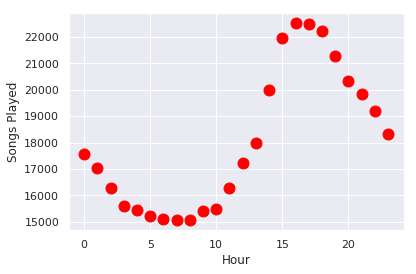

In [ ]:
sb.set()
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"], s=120, c='red')
plt.xlabel("Hour")
plt.ylabel("Songs Played");

#### Churn Rate by gender

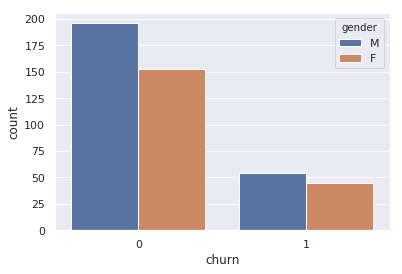

In [ ]:
churn_by_gender = df2.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sb.barplot(x='churn', y='count', hue='gender', data=churn_by_gender)

**At what level were the users before they churned?**

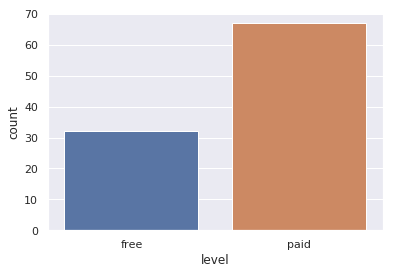

In [ ]:
df_churnlevel = df2.filter(df2.page=="Cancellation Confirmation").groupby("level").count().toPandas()
sb.barplot(x="level", y="count", data=df_churnlevel)

#### Create Features from the Churned Customers/Users

For predicting the churn rate, we have to look at different features and user behaviors by extracting the features below.

1. total_songs: Total songs a user listened to: Is the user actively engaged?
2. adverts: Total number of adverts served to a user: What type of Ads the user has seen while using the app?
3. songs_persession: Number of songs a user listens to time per session: Each time a user logs in, how many songs do they listen to before logging out? This will be a good indication if they like the platform.
4. num_thumbsup: How many songs did they give a thumbs-up)
5. num_thumbsdown: How many songs did the user dislike by giving a thumbs down
6. num_playlist: Number of songs a user added to their playlist
7. friends_added: How many friends each user added. Can there be peer pressure from friends influencing user decisions?
8. gender: What's the gender distribution and how does this affect user behaviour? The behaviour of the female users may be different from that of the male users as seen from the exploratory analysis of the gender
9. level: Which users are on the free version or paid subscription.
10. errors: How many errors have the user experienced since signing up on the app?

**Label**
11. churn: convert the churn column to a label.

**Merge all features and labels**

**F1: Total songs a user listened to**

In [ ]:
f1 = df2 \
    .select('userId','song') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'total_songs')
f1.describe().show()

+-------+------------------+------------------+
|summary|            userId|       total_songs|
+-------+------------------+------------------+
|  count|               448|               448|
|   mean| 67520.34821428571|1178.5825892857142|
| stddev|105964.58428485188|1380.6279647524048|
|    min|                10|                 3|
|    max|                99|              9767|
+-------+------------------+------------------+



**F2:Total number of adverts served to a user**

In [ ]:
f2 = df2 \
    .select('userId', 'page') \
    .where(df2.page == 'Roll Advert') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'adverts')
    
f2.describe().show()


+-------+------------------+------------------+
|summary|            userId|           adverts|
+-------+------------------+------------------+
|  count|               395|               395|
|   mean| 64918.06329113924|19.678481012658228|
| stddev|102712.13991323955| 21.76408856318852|
|    min|               100|                 1|
|    max|                99|               187|
+-------+------------------+------------------+



**F3: Number of songs a user listens to per session**

In [ ]:
f3 = df2 \
    .where('page == "NextSong"') \
    .groupby(['userId', 'sessionId']) \
    .count() \
    .groupby(['userId']) \
    .agg({'count':'avg'}) \
    .withColumnRenamed('avg(count)', 'songs_persession')

f3.show()


+------+------------------+
|userId|  songs_persession|
+------+------------------+
|   296|              22.4|
|100010|              48.0|
|200002|              62.0|
|   125|20.666666666666668|
|     7|              30.8|
|   124|           114.125|
|    51|              53.2|
|200037|17.428571428571427|
|   169|              14.0|
|   205|             209.6|
|   272|              48.5|
|   282| 93.89285714285714|
|    15|101.94444444444444|
|   234| 72.78260869565217|
|   232| 81.56521739130434|
|    54|            64.625|
|200043|             51.25|
|   155|              35.0|
|100014|              83.0|
|   154|             23.25|
+------+------------------+
only showing top 20 rows



**F4: How many songs did a user like? (Thumbs Up)**

In [ ]:
f4 = df2 \
    .select('userId','page') \
    .where(df2.page == 'Thumbs Up') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'num_thumbsup') 

f4.describe().show()
    


+-------+------------------+-----------------+
|summary|            userId|     num_thumbsup|
+-------+------------------+-----------------+
|  count|               439|              439|
|   mean| 67308.81548974942|54.27334851936219|
| stddev|106228.80408254794|69.94135178778984|
|    min|                10|                1|
|    max|                99|              506|
+-------+------------------+-----------------+



**F5: How many songs did the user dislike by giving a thumbs down**

In [ ]:
f5 = df2 \
    .select('userId','page') \
    .where(df2.page == 'Thumbs Down') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'num_thumbsdown')

f5.describe().show()

+-------+------------------+------------------+
|summary|            userId|    num_thumbsdown|
+-------+------------------+------------------+
|  count|               389|               389|
|   mean| 70031.19537275065|12.624678663239074|
| stddev|106895.73735311364|13.582432851937993|
|    min|                10|                 1|
|    max|                99|                80|
+-------+------------------+------------------+



**F6: Number of songs added to playlist**

In [ ]:
f6 = df2 \
    .select('userId','page') \
    .where(df2.page == 'Add to Playlist') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'num_playlist')

f6.show()

+------+------------+
|userId|num_playlist|
+------+------------+
|   296|           3|
|100010|           1|
|200002|           6|
|   125|           2|
|    51|           8|
|   124|          45|
|     7|           6|
|200037|           4|
|   205|          25|
|   272|           3|
|   282|          66|
|   232|          61|
|    15|          57|
|   234|          51|
|    54|          15|
|200043|          23|
|   155|           4|
|   154|           4|
|   132|           4|
|100014|          11|
+------+------------+
only showing top 20 rows



**F7: Number of friends User Added**

In [ ]:
f7 = df2 \
    .select('userId','page') \
    .where(df2.page == 'Add Friend') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'friends_added') 

f7.show()

+------+-------------+
|userId|friends_added|
+------+-------------+
|   296|            2|
|100010|            3|
|200002|            2|
|   125|            3|
|   124|           26|
|     7|           16|
|    51|            3|
|200037|            2|
|   205|           21|
|   169|            6|
|    54|           20|
|   282|           79|
|   234|           17|
|   232|           43|
|    15|           32|
|200043|           12|
|100014|            3|
|   154|            4|
|   132|            4|
|300027|            4|
+------+-------------+
only showing top 20 rows



**F8: Gender distribution**

In [ ]:
# Gender
f8 = df2 \
    .select("userId", "gender") \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int'))
f8.describe().show(5)
f8.show()

+-------+------------------+------------------+
|summary|            userId|            gender|
+-------+------------------+------------------+
|  count|               448|               448|
|   mean| 67520.34821428571|0.4419642857142857|
| stddev|105964.58428485185|0.4971756279079041|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+

+------+------+
|userId|gender|
+------+------+
|   188|     1|
|   234|     0|
|    44|     1|
|   273|     0|
|    46|     1|
|   220|     1|
|    41|     1|
|   186|     0|
|   254|     0|
|   280|     0|
|100035|     1|
|   294|     1|
|    72|     1|
|300023|     1|
|100010|     1|
|    39|     1|
|   287|     0|
|   210|     1|
|200026|     0|
|   207|     0|
+------+------+
only showing top 20 rows



#### F9: Level: Which users are on the free version or paid subscription

In [ ]:
f9 = df2 \
    .select('userId', 'level') \
    .dropDuplicates() \
    .replace(['free', 'paid'], ['0', '1'], 'level') \
    .select('userId', col('level').cast('int'))

f9.show()

+------+-----+
|userId|level|
+------+-----+
|100021|    0|
|100029|    0|
|    94|    1|
|    18|    0|
|200050|    1|
|200021|    0|
|   185|    0|
|   241|    1|
|200001|    0|
|   227|    0|
|   289|    1|
|300022|    1|
|   207|    0|
|     6|    0|
|   190|    1|
|   132|    0|
|   112|    0|
|   168|    1|
|100035|    1|
|   165|    0|
+------+-----+
only showing top 20 rows



#### F10: Number of Errors: How many errors have the user experienced since signing up on the app

In [ ]:
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df2 = df2.withColumn('activity_time', convert_ts('ts'))
df2 = df2.withColumn('registration_time', convert_ts('registration'))

In [ ]:
f10 = df2 \
    .select('userId', 'page') \
    .where(df2.page == 'Error') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'errors')
f10.show()

+------+------+
|userId|errors|
+------+------+
|    51|     2|
|   205|     1|
|   282|     4|
|   232|     1|
|    15|     1|
|   234|     2|
|   155|     1|
|   101|     6|
|   279|     3|
|   138|     1|
|300017|     4|
|    29|     5|
|    69|     1|
|    42|     4|
|300033|     1|
|    87|     5|
|    73|     1|
|300035|     5|
|    30|     7|
|   113|     2|
+------+------+
only showing top 20 rows



**F11: Churn Label**

In [ ]:
f11_label = df2 \
    .select('userId', col('churn').alias('label').cast('int')) \
    .dropDuplicates() 

f11_label.show()

+------+-----+
|userId|label|
+------+-----+
|100010|    1|
|200002|    1|
|   296|    1|
|   125|    0|
|   124|    1|
|    51|    1|
|     7|    0|
|200037|    1|
|   169|    0|
|   205|    0|
|   272|    0|
|    15|    0|
|   232|    0|
|   234|    1|
|   282|    0|
|    54|    1|
|   155|    0|
|200043|    0|
|100014|    1|
|   132|    1|
+------+-----+
only showing top 20 rows



**Merge all the features and label**

In [ ]:
merged_features = f1.join(f2,'userId','inner') \
    .join(f3,'userId','inner') \
    .join(f4,'userId','inner') \
    .join(f5,'userId','inner') \
    .join(f6,'userId','inner') \
    .join(f7,'userId','inner') \
    .join(f8,'userId','inner') \
    .join(f9,'userId','inner') \
    .join(f10,'userId','inner') \
    .join(f11_label,'userId','inner') \
    .drop('userId') \
    .fillna(0)

merged_features.show()

+-----------+-------+------------------+------------+--------------+------------+-------------+------+-----+------+-----+
|total_songs|adverts|  songs_persession|num_thumbsup|num_thumbsdown|num_playlist|friends_added|gender|level|errors|label|
+-----------+-------+------------------+------------+--------------+------------+-------------+------+-----+------+-----+
|        328|      1|              53.2|          16|             1|           8|            3|     0|    1|     2|    1|
|       2325|     38| 81.56521739130434|          97|            17|          61|           43|     1|    0|     1|    0|
|       2325|     38| 81.56521739130434|          97|            17|          61|           43|     1|    1|     1|    0|
|       2021|     30| 72.78260869565217|          91|            22|          51|           17|     0|    0|     2|    1|
|       2021|     30| 72.78260869565217|          91|            22|          51|           17|     0|    1|     2|    1|
|       3191|     37| 93

### Modeling

Split the full dataset into train and test sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine the winning model based on test accuracy and report results on the test set. Since the churned users are a fairly small subset, I basically used the F-1 score as the metric to optimize.

#### Data Pre-Processing

**Vectorize the features for training, validation and testing**

In [ ]:
feature_columns = ['gender', 'level', 'songs_persession', 'total_songs', 'num_playlist', 'friends_added', 'errors', 'adverts', 'num_thumbsup', 'num_thumbsdown']

In [ ]:
vec_assembler = VectorAssembler(inputCols=feature_columns, outputCol="vectorizedFeatures")
vec_data = vec_assembler.transform(merged_features)
vec_data.show()

+-----------+-------+------------------+------------+--------------+------------+-------------+------+-----+------+-----+--------------------+
|total_songs|adverts|  songs_persession|num_thumbsup|num_thumbsdown|num_playlist|friends_added|gender|level|errors|label|  vectorizedFeatures|
+-----------+-------+------------------+------------+--------------+------------+-------------+------+-----+------+-----+--------------------+
|        328|      1|              53.2|          16|             1|           8|            3|     0|    1|     2|    1|[0.0,1.0,53.2,328...|
|       2325|     38| 81.56521739130434|          97|            17|          61|           43|     1|    0|     1|    0|[1.0,0.0,81.56521...|
|       2325|     38| 81.56521739130434|          97|            17|          61|           43|     1|    1|     1|    0|[1.0,1.0,81.56521...|
|       2021|     30| 72.78260869565217|          91|            22|          51|           17|     0|    1|     2|    1|[0.0,1.0,72.78260...|

**Standardize the features**. This step takes care of values with very wide margins from the rest of the data. The data is rescaled int a certain range in order to make two different attributes to be directly comparable. This also means massaging the data into a normal range. 

This is achieved by subtracting the mean of each feature divided by each features standard deviation, `x' = (x - avg(x))/stddev`

Where `x` is the original feature vector, `avg(x)` is the mean of that feature vector, and `stddev` is its standard deviation.

**Standard Scaler**

In [ ]:
std_scaler= StandardScaler(inputCol="vectorizedFeatures", outputCol=("features"), withStd=True)
std_scaler = std_scaler.fit(vec_data)
vec_data = std_scaler.transform(vec_data)

In [ ]:
vec_data.head()

Row(total_songs=328, adverts=1, songs_persession=53.2, num_thumbsup=16, num_thumbsdown=1, num_playlist=8, friends_added=3, gender=0, level=1, errors=2, label=1, vectorizedFeatures=DenseVector([0.0, 1.0, 53.2, 328.0, 8.0, 3.0, 2.0, 1.0, 16.0, 1.0]), features=DenseVector([0.0, 1.9972, 1.6951, 0.2009, 0.1996, 0.1105, 1.0834, 0.0376, 0.1895, 0.0628]))

In [ ]:
vec_data = vec_data.select(['label', 'features'])
vec_data = vec_data.selectExpr("label as label", "features as features")

#### Data Splitting for Modeling

Split the data for developing our model into train and test.

In [ ]:
train, test = vec_data.randomSplit([0.7, 0.3], seed=42)
# test, validation = rest.randomSplit([0.3, 0.7], seed=42)

In [ ]:
train.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
test.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
# validation.printSchema()

**Baseline Model**

Using binary models where all users cancel as `(churn=1)` and all users stay of the platform as `churn=0`. Performance of these 2 models will be based on their accuracy and f1-score.

In [ ]:
base_0 = test.withColumn('prediction', lit(0.0))

test_eval = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Baseline evaluation:")
print("Accuracy:{}".format(test_eval.evaluate(base_0, \
                                              {test_eval.metricName: "accuracy"})))

print("F-1 Score: {}".format(test_eval.evaluate(base_0, \
                                                {test_eval.metricName: "f1"})))

Baseline evaluation:
Accuracy:0.7747747747747747
F-1 Score: 0.6764531028490418


In [ ]:
base_0.head()

Row(label=0, features=DenseVector([0.0, 0.0, 2.9917, 1.954, 1.6464, 2.9106, 2.1668, 1.3921, 1.5756, 1.8212]), prediction=0.0)

In [ ]:
base_1 = test.withColumn('prediction', lit(1.0))

test_eval = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Baseline evaluation:")
print("Accuracy:{}".format(test_eval.evaluate(base_1, {test_eval.metricName: "accuracy"})))
print("F-1 Score: {}".format(test_eval.evaluate(base_1, {test_eval.metricName: "f1"})))

Baseline evaluation:
Accuracy:0.22522522522522523
F-1 Score: 0.08280339162692105


In [ ]:
base_1.head()

Row(label=0, features=DenseVector([0.0, 0.0, 2.9917, 1.954, 1.6464, 2.9106, 2.1668, 1.3921, 1.5756, 1.8212]), prediction=1.0)

### Random Forest

In [ ]:
# initialize classifier
random_forest = RandomForestClassifier()

# set evaluator
f1_eval = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_rf = CrossValidator(estimator=random_forest,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_eval,
                          numFolds=2)



In [ ]:
start = time()
cvModel_rf = crossval_rf.fit(train)
cvModel_rf.save('cvModel_rf.model')
end = time()
cvModel_rf.avgMetrics
print('Training completed after {} seconds'.format(end - start))



Training completed after 197.6955485343933 seconds


In [ ]:
result_rf = cvModel_rf.transform(test)

In [ ]:
test_eval = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Evaluation Metrics from Random Forest:")

print("Accuracy:{}".format(test_eval.evaluate(result_rf, \
                                              {test_eval.metricName: "accuracy"})))

print("F-1 Score: {}".format(test_eval.evaluate(result_rf, \
                                                {test_eval.metricName: "f1"})))


Evaluation Metrics from Random Forest:
Accuracy:0.8198198198198198
F-1 Score: 0.777678994784258


### Logistic Regression

In [ ]:
# initialize classifier
logreg = LogisticRegression(maxIter=10)

# set evaluator
f1_eval = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_logreg = CrossValidator(estimator=logreg,
                          evaluator=f1_eval, 
                          estimatorParamMaps=paramGrid,
                          numFolds=2)

In [ ]:
start = time()
cvModel_logreg = crossval_logreg.fit(train)
cvModel_logreg.save('cvModel_logreg.model')
end = time()
cvModel_logreg.avgMetrics
print('Training completed in {} seconds'.format(end - start))

Training completed in 144.39231276512146 seconds


In [ ]:
result_logreg = cvModel_logreg.transform(test)

test_eval = MulticlassClassificationEvaluator(predictionCol="prediction")

print('Evaluation from Logistic Regression:')
print('Accuracy: {}'.format(test_eval.evaluate(result_logreg, \
                                               {test_eval.metricName: "accuracy"})))

print('F-1 Score:{}'.format(test_eval.evaluate(result_logreg, \
                                               {test_eval.metricName: "f1"})))

Evaluation from Logistic Regression:
Accuracy: 0.7837837837837838
F-1 Score:0.7332147937411095


### Gradient Boosting Trees (GBT)

Gradient Boosting: GBT build trees one at a time, where each new tree helps to correct errors made by previously trained tree.

In [ ]:
# initialize classifier
gbt = GBTClassifier(maxIter=10,seed=42)

# set evaluator
f1_eval = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_eval,
                          numFolds=2)

In [ ]:
start = time()
cvModel_gbt = crossval_gbt.fit(train)
cvModel_gbt.save('cvModel_gbt.model')
end = time()
cvModel_gbt.avgMetrics
print('Training completed in {} minutes'.format(end - start))

In [ ]:
result_gbt = cvModel_gbt.transform(test)

In [ ]:
test_eval = MulticlassClassificationEvaluator(predictionCol="prediction")

print('Evaluation from Gradient Boosted Trees:')
print('Accuracy: {}'.format(test_eval.evaluate(result_gbt, \
                                               {test_eval.metricName: "accuracy"})))

print('F-1 Score:{}'.format(test_eval.evaluate(result_gbt, \
                                               {test_eval.metricName: "f1"})))

The time and resources that went into training the 3 models is quiite significant.
From the 3 different models trained here, it is more beneficial and cost effective to choose the best performing model.

**Choose the best Model**

In [ ]:
gbt_final = GBTClassifier(maxIter=10,seed=42, maxDepth=4)
best_model = gbt_final.fit(train)
final_model = best_model.transform(test)

**Final evaluation metrics from chosen model**

In [ ]:
final_eval = MulticlassClassificationEvaluator(predictionCol="prediction")

print('Final Test Metrics from Gradient Boosted Trees:')
print('Accuracy: {}'.format(final_eval.evaluate(final_model, \
                                                {final_eval.metricName: "accuracy"})))
print('F-1 Score:{}'.format(final_eval.evaluate(final_model, \
                                                {final_eval.metricName: "f1"})))

### Confusion Matrix of the Selected Model (GBT)

In [ ]:
tp = final_model.filter("label = 1 and prediction = 1").count()
fp = final_model.filter("label = 0 and prediction = 1").count()
fn = final_model.filter("label = 1 and prediction = 0").count()

precision = tp / (tp + fp) 
recall = tp / (tp + fn)
F1 = 2*precision*recall / (precision+recall)
print(precision, recall, F1)
